# Face Detection Comparator
The purpose of this notebook is to compare the performance of different approaches to face detection to find out the best one to use for real-time scenarios.<br>
In particular, the models tested are:
- Haar Cascades
- MTCNN
- cvlib
- DNN Face Detector in OpenCV

These approaches are tested on 27 pictures, where the first 26 are taken from the WIDER Validation Dataset (http://shuoyang1213.me/WIDERFACE/).
<br>Each picture represents a different real-world situation, for example:

- 0.jpg: Parade
- 1.jpg: Handshaking
... (Check the first 26 directory of the WIDER dataset)
- 27.jpg: No faces picture (does not belong to WIDER)<br>

Check "real_labels.txt" to know the exact number of faces in each picture.

### Imports and settings

In [14]:
import cv2
import numpy as np
import cvlib as cv
from mtcnn import MTCNN
import matplotlib.pyplot as plt
import pandas as pd
from random import randrange

In [15]:
# Number of pictures used to compare performance
dataset_size = 27

# Vectors which will count the number of faces detected in every picture for each model are initialized
haar_numfaces = np.zeros(dataset_size, dtype=int)
mtcnn_numfaces = np.zeros(dataset_size, dtype=int)
cvlib_numfaces = np.zeros(dataset_size, dtype=int)
dnn_numfaces = np.zeros(dataset_size, dtype=int)

## Haar Cascade
Proposed way back in 2001 by Paul Viola and Micheal Jones in their paper, <i>Rapid Object Detection using a Boosted Cascade of Simple Features.</i>.<br> It is super fast to work with and like the simple CNN, it extracts a lot of features from images. The best features are then selected via Adaboost.<br> But applying all these features in a sliding window will still take a lot of time. So they introduced a <b>Cascade of Classifiers</b>, where the features are grouped. <br> It's important to notice that the model is better at finding <b>frontal faces</b>.

In [16]:
# Load weights of the cascade of classifiers from xml file 
face_cascade = cv2.CascadeClassifier('models/haarcascade_frontalface_default.xml')

In [17]:
%%time
print("Haar Cascade processing...")

for i in range(dataset_size):

    # Image is read and converted to grayscale since Haar classifiers require grayscale images
    img = cv2.imread("images/"+str(i)+".jpg")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Face detection is started with scaleFactor = 1.1 and minNeighbors = 3
    face_info = face_cascade.detectMultiScale(gray, 1.1, 4)

    # print("Image "+str(i)+" processing...")

    haar_numfaces[i] = len(face_info)

    # For each face detected we draw a bounding box to localize it
    for faces in face_info:
        x,y,width,height = faces
        cv2.rectangle(img,(x,y),(x+width,y+height),(0, 165, 255),5)

    # The image with bounding boxes is saved
    cv2.imwrite("haar_output/haar_"+str(i)+".jpg",img)

Haar Cascade processing...
CPU times: user 7.07 s, sys: 119 ms, total: 7.19 s
Wall time: 1.58 s


## MTCNN
Introduced by Kaipeng Zhang, et al. in 2016 in their paper, <i>Joint Face Detection and Alignment Using Multi-task Cascaded Convolutional Networks.</i> <br> It not only detects the face but also detects five key points as well. It uses a <b>cascade structure </b> with three stages of CNN. <br>First, a fully convolutional network is used to obtain candidate windows and their bounding box regression vectors. <br>Next, these candidates are passed to another CNN which rejects a large number of false positives and performs calibration of bounding boxes. <br>In the final stage, the facial landmark detection is performed.

In [18]:
# The model is initialized
face_detector = MTCNN()

In [19]:
%%time
print("MTCNN processing...")

for i in range(dataset_size):

    # Image is read and converted to RGB
    img = cv2.cvtColor(cv2.imread("images/"+str(i)+".jpg"), cv2.COLOR_BGR2RGB)
   
    # Face detection is performed
    face_info = face_detector.detect_faces(img)
    
    # print("Image "+str(i)+" processing...")
    
    mtcnn_numfaces[i] = len(face_info)

    # For each face detected we draw a bounding box to localize it
    for faces in face_info:
        x,y,width,height = faces["box"]
        cv2.rectangle(img,(x,y),(x+width,y+height),(50,205,50),5)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # The image with bounding boxes is saved
    cv2.imwrite("mtcnn_output/mtcnn_"+str(i)+".jpg",img)

MTCNN processing...
1/1 [==============================] - 0s 112ms/step


2022-09-24 09:34:04.739281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-09-24 09:34:04.888133: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13/20 [==================>...........] - ETA: 0s

2022-09-24 09:34:05.972138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/2 [==============>...............] - ETA: 0s

2022-09-24 09:34:06.302415: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 19ms/step
CPU times: user 31.5 s, sys: 4.75 s, total: 36.2 s
Wall time: 34.7 s


## cvlib
<b>cvlib</b> is a simple, easy-to-use, high level, open-source Computer Vision library for Python. <br> The library was developed with a focus on enabling easy and fast experimentation. <br>Most of the Guided principles that <B>cvlib</b> has are heavily inspired by the famous <b>Keras</b> library (Deep Learning library used on top of TensorFlow).

In [20]:
%%time
print("cvlib processing...")

for i in range(dataset_size):
    
    # Image is read
    img = cv2.imread("images/"+str(i)+".jpg")

    # Face detection is performed
    face_info, _ = cv.detect_face(img)

    # print("Image "+str(i)+" processing...")

    cvlib_numfaces[i] = len(face_info)

    # For each face detected we draw a bounding box to localize it
    for faces in face_info:
        x,y,z,k = faces
        cv2.rectangle(img,(x,y),(z,k),(0,0,255),5)

    # The image with bounding boxes is saved
    cv2.imwrite("cvlib_output/cvlib_"+str(i)+".jpg",img)

cvlib processing...
CPU times: user 2.1 s, sys: 138 ms, total: 2.24 s
Wall time: 829 ms


## DNN Face Detector in OpenCV
It is a <b>Caffe model</b> which is based on the Single Shot-Multibox Detector (SSD) and uses ResNet-10 architecture as its backbone.<br> It was introduced post OpenCV 3.3 in its deep neural network module.

In [21]:
# The network is loaded using cv2.dnn.readNetFromCaffe and the model's layers and weights as passed its arguments.
modelFile = "models/res10_300x300_ssd_iter_140000.caffemodel"
configFile = "models/deploy.prototxt.txt"
net = cv2.dnn.readNetFromCaffe(configFile, modelFile)

In [22]:
%%time
print("DNN Face Detector processing...")

for i in range(dataset_size):
    
    # Image is read
    img = cv2.imread("images/"+str(i)+".jpg")

    # Height and width of the image are extracted
    h, w = img.shape[:2]

    # To achieve the best accuracy I ran the model on BGR images resized to 300x300 
    # applying mean subtraction of values (104, 177, 123) for each blue, green and red channels correspondingly.
    blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 1.0,(600, 600), (104.0, 117.0, 123.0))
    net.setInput(blob)

    # Face detection is performed
    faces = net.forward()

    # print("Image "+str(i)+" processing...")


    # For each face detected we draw a bounding box to localize it
    for j in range(faces.shape[2]):
        confidence = faces[0, 0, j, 2]
        if confidence > 0.5:
            dnn_numfaces[i] = dnn_numfaces[i] + 1
            box = faces[0, 0, j, 3:7] * np.array([w, h, w, h])
            (x, y, x1, y1) = box.astype("int")
            cv2.rectangle(img, (x, y), (x1, y1), (177,36,199), 5)

    # The image with bounding boxes is saved
    cv2.imwrite("dnn_output/dnn_"+str(i)+".jpg",img)

DNN Face Detector processing...
CPU times: user 7.06 s, sys: 177 ms, total: 7.24 s
Wall time: 2.02 s


## Comparing models
For each picture and for each model, the number of faces detected by the model are plotted in an hystogram. Then, the number of faces detected by the models are compared to the real number of faces in the picture (extracted from WIDER labels). <br>
To properly compare performances of face detection methods we should take into account also the position of the faces detected, and so the bounding boxes coordinates. In fact, the number of face detected alone is not sufficient to prove that a model is good. <br>
However, since the final goal is to use the detection model to do futher operations with the faces detected, we can also compare the models by simply observing the results obtained for different pictures.

<AxesSubplot:>

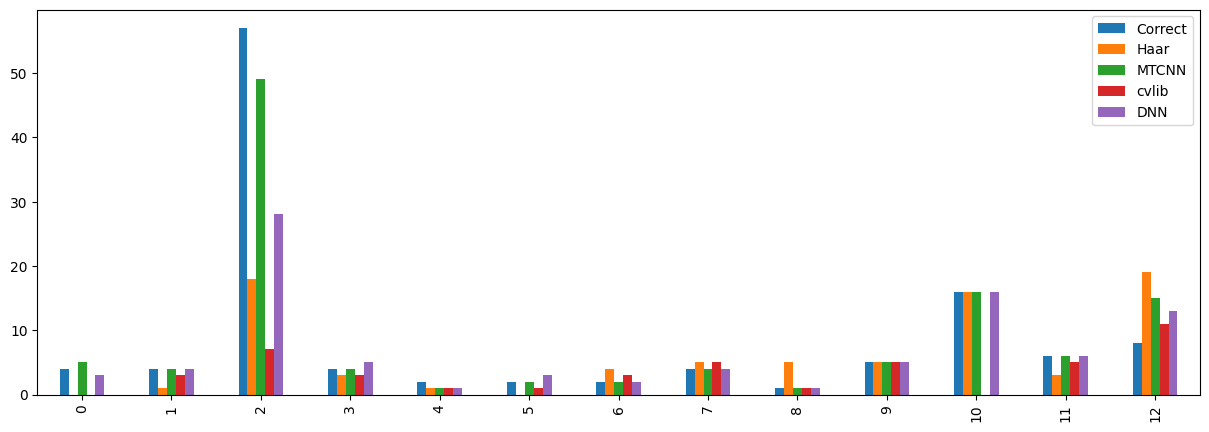

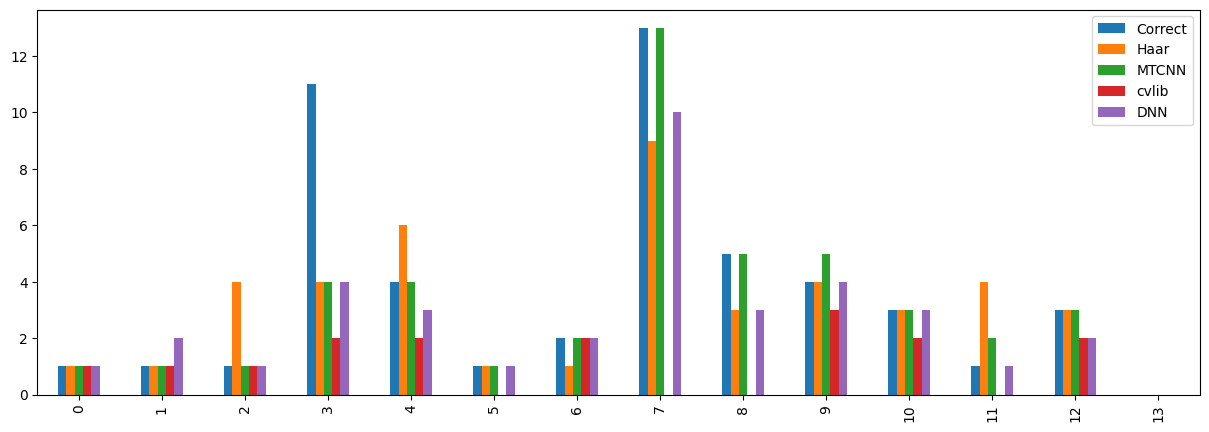

In [23]:
# Real number of faces are extracted from the text file
real_numfaces = np.loadtxt("real_labels.txt",dtype="int")

# In these dataframes are stored the number of faces detected by the models (and the real number too)

# For the first 13 images
df1 = pd.DataFrame(
    {
        "Correct": real_numfaces[0:13],
        "Haar": haar_numfaces[0:13],
        "MTCNN": mtcnn_numfaces[0:13],
        "cvlib": cvlib_numfaces[0:13],
        "DNN": dnn_numfaces[0:13]
    }
)

# For the last 14 images
df2 = pd.DataFrame(
    {
        "Correct": real_numfaces[13:],
        "Haar": haar_numfaces[13:],
        "MTCNN": mtcnn_numfaces[13:],
        "cvlib": cvlib_numfaces[13:],
        "DNN": dnn_numfaces[13:]
    }
)

df1.plot(kind='bar',figsize=(15,5))
df2.plot(kind='bar',figsize=(15,5))

Below, we measure a sort of <b>accuracy</b> for each approach. <br>
This measure is obtained by summing the total number of faces detected by each model and divided by the real number of faces in every picture.<br>
Obviously, we're not considering that there might be false positives that can raise this measure.<br>
However, by doing this we can have a clue on which method can localize the highest number of faces.

In [24]:
total_faces = np.sum(real_numfaces)
haar_acc = np.sum(haar_numfaces)/total_faces
mtcnn_acc = np.sum(mtcnn_numfaces)/total_faces
cvlib_acc = np.sum(cvlib_numfaces)/total_faces
dnn_acc = np.sum(dnn_numfaces)/total_faces

print("--- Accuracies ---")
print("Haar: "+str(haar_acc))
print("MTCNN: "+str(mtcnn_acc))
print("cvlib: "+str(cvlib_acc))
print("DNN: "+str(dnn_acc))

--- Accuracies ---
Haar: 0.7515151515151515
MTCNN: 0.9636363636363636
cvlib: 0.3696969696969697
DNN: 0.7757575757575758


Here a random image is taken from the example set and the results obtained by the four models is shown.
1) Orange boxes : Haar
2) Green boxes : MTCNN
3) Red boxes : cvlib
4) Purple boxes : DNN

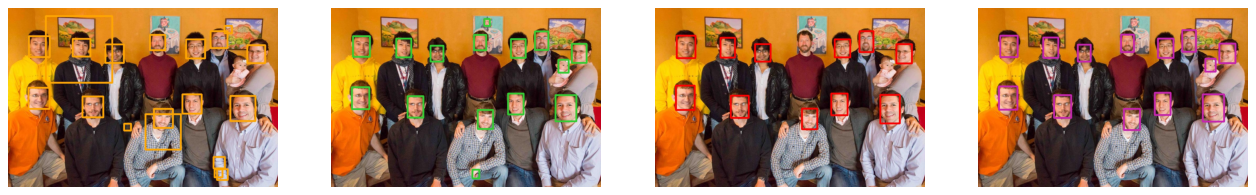

In [25]:
def showImagesHorizontally(list_of_files):
    fig = plt.figure(figsize=(20, 20), dpi=80)
    number_of_files = len(list_of_files)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = plt.imread(list_of_files[i])
        plt.imshow(image)
        plt.axis('off')

r = randrange(27)
showImagesHorizontally(["haar_output/haar_"+str(r)+".jpg","mtcnn_output/mtcnn_"+str(r)+".jpg","cvlib_output/cvlib_"+str(r)+".jpg","dnn_output/dnn_"+str(r)+".jpg"])